# LAB: Feature Selection

En este lab vamos a explorar selección de características. Seguiremos trabajando sobre el dataset de Titanic.

Ante que nada, carguemos algunas cosas:

- Paquetes estándar
- El dataset

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

df = pd.read_csv('../Data/Titanic.csv')

In [2]:
X = df[[u'Pclass', u'Sex', u'Age', u'SibSp', u'Parch', u'Fare', u'Embarked']]
y = df[u'Survived']

## 1. Preprocesamiento

Va a ser necesario realizar algunas tareas de preprocesamiento para este dataset:

1. Estandarizar la edad (`age`) y la tarifa (`fare`)
2. Construir algunas variables dummies para algunas variables relevantes (tales como `P_class`, `Embarked`, `Male`)

In [3]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
cols = df[['Pclass','Sex', 'Embarked']]
dummies = pd.get_dummies(cols, drop_first=True)
dummies.head()

,Pclass,Sex_male,Embarked_Q,Embarked_S
0,3,1,0,1
1,1,0,0,0
2,3,0,0,1
3,1,0,0,1
4,3,1,0,1


In [5]:
cols2 = df[['Age','Fare']].fillna(df[['Age','Fare']].mean())

In [6]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
std = scaler.fit_transform(cols2)
std = pd.DataFrame(std, columns=['std_Age','std_Fare'])

In [7]:
#dummies.reset_index(drop=False)
#std.reset_index(drop=False)

In [8]:
X = pd.concat([dummies, std, df[['SibSp','Parch']]],axis=1)

## 2. Feature selection

Utilicemos el método "SelectKBest" de scikit learn a ver cuáles son las top 5 características.

Cuáles son?


Guardémoslas en una variable llamada "kbest_columns"

In [9]:
from sklearn.feature_selection import SelectKBest, f_classif

In [10]:
selector = SelectKBest(f_classif, k=5)
selected_data = selector.fit_transform(X, y)
kbest_columns = X.columns[selector.get_support()]
Xbest = pd.DataFrame(selected_data, columns=kbest_columns)
Xbest.head()

,Pclass,Sex_male,Embarked_S,std_Fare,Parch
0,3.0,1.0,1.0,-0.502445,0.0
1,1.0,0.0,0.0,0.786845,0.0
2,3.0,0.0,1.0,-0.488854,0.0
3,1.0,0.0,1.0,0.420730,0.0
4,3.0,1.0,1.0,-0.486337,0.0


## 3. Eliminación recursiva de características

En Scikit Learn también vamos a encontrar una clase para realizar una eliminación recursiva de características. La misma se llama "RFECV". Usémosla en combinación de un modelo de regresión logística para ver qué características serán conservadas con este método.

Guardémoslas en una variable llamada "rfecv_columns"

In [11]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression

In [12]:
estimator = LogisticRegression()
selector = RFECV(estimator, step=1, cv=5)
selector = selector.fit(X, y)
rfecv_columns = X.columns[selector.support_]
rfecv_columns

C:\Users\mbeati\AppData\Local\Continuum\anaconda3\envs\dsdh2\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mbeati\AppData\Local\Continuum\anaconda3\envs\dsdh2\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mbeati\AppData\Local\Continuum\anaconda3\envs\dsdh2\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mbeati\AppData\Local\Continuum\anaconda3\envs\dsdh2\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mbeati\AppData\Local\Co

Index(['Pclass', 'Sex_male', 'Embarked_Q', 'Embarked_S', 'std_Age', 'std_Fare',
       'SibSp', 'Parch'],
      dtype='object')

## 4. Coeficientes de Regresión Logística

Veamos si los coeficientes de una RL se condicen.

- Creá un modelo de regresión logística
- Ejecutá un grid search sobre los parámetros "penalty type" y "C strength" para encontrar la mejor combinación
- Ordená los coeficientes obtenidos por valor absoluto (módulo). El top 5 coincide con los de arriba? Por qué/Por qué no? (Pista: Están todos los valores en la misma escala?)

Guardemos las que querramos mantener en una variable llamada "lr_columns"

In [13]:
from sklearn.model_selection import GridSearchCV

In [14]:
model = GridSearchCV(LogisticRegression(solver='liblinear'), {'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
                                            'penalty': ['l1', 'l2']}, cv=3)
model.fit(X, y)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [15]:
model.best_estimator_

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [16]:
model.best_score_

0.7946127946127947

In [17]:
coeffs = pd.DataFrame(model.best_estimator_.coef_, columns = X.columns)
coeffs_t = coeffs.transpose()
coeffs_t.columns = ['Surv coeff']
coeffs_t.abs().sort_values('Surv coeff', ascending=False)

,Surv coeff
Sex_male,2.495319
Pclass,0.918604
std_Age,0.457021
SibSp,0.303894
Embarked_S,0.284436
std_Fare,0.170868
Parch,0.074052
Embarked_Q,0.053110


In [18]:
lr_columns = coeffs.columns[(coeffs.abs() > 0.3).values[0]]
lr_columns

Index(['Pclass', 'Sex_male', 'std_Age', 'SibSp'], dtype='object')

## 5. Comparar sets de características

Usá el "best estimator" del punto anterior sobre los sets de características obtenidos:

- "kbest_columns"
- "rfecv_columns"
- "lr_columns"
- "all_columns"

Usá validación cruzada (cross_val_score) para evaluar los modelos 
Preguntas:

- Cuál obtuvo mejores resultados?
- Hay diferencias signigicativas?
- Cuál es la mejor opción? Por qué?

In [19]:
from sklearn.model_selection import cross_val_score

def score(X):
    scores = cross_val_score(model.best_estimator_, X, y, cv=3)
    return scores.mean(), scores.std()

all_scores = [
    score(X[kbest_columns]),
    score(X[rfecv_columns]),
    score(X[lr_columns]),
    score(X)]

pd.DataFrame(all_scores, columns=['mean score', 'std score'], index = ['kbest', 'rfecv', 'lr', 'all'])


,mean score,std score
kbest,0.775533,0.008837
rfecv,0.794613,0.004762
lr,0.785634,0.001587
all,0.794613,0.004762


## Bonus

Creá un grágico de barras para mostrar los coeficientes de la regresión logística.

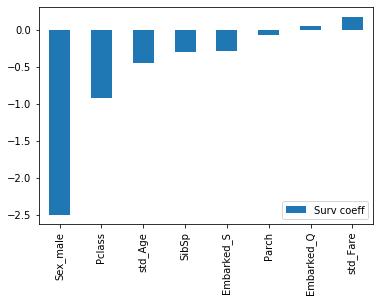

In [20]:
coeffs_t.sort_values('Surv coeff').plot(kind='bar')